In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
import cv2

In [27]:
import torch
import torchvision.transforms as transforms

# Example tensor with shape [1, 180, 320, 3]
tensor = torch.randn(1, 180, 320, 3)
print(tensor.shape)
# Convert the tensor to shape [1, 3, 320, 180]
tensor = tensor.permute(0, 3, 2, 1)
print(tensor.shape)
# Remove the batch dimension for transformation
tensor = tensor.squeeze(0)  # Now the shape is [3, 320, 180]
print(tensor.shape)
# Define the transformations
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),  # Resize the image
        transforms.RandomHorizontalFlip(),  # Apply horizontal flip
        transforms.ColorJitter(brightness=0.5),  # Randomly change brightness
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize
    ]
)

print(type(tensor))
# Apply the transformations (this expects the tensor to be in [C, H, W] format)
transformed_tensor = transform(tensor)
print(transformed_tensor.shape)
# Add the batch dimension back if needed
transformed_tensor = transformed_tensor.unsqueeze(0)

# Print the shape to verify
print(transformed_tensor.shape)

torch.Size([1, 180, 320, 3])
torch.Size([1, 3, 320, 180])
torch.Size([3, 320, 180])
<class 'torch.Tensor'>
torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])


In [2]:
def calc_mean_std_of_each_channel(path, in_channels=3):
    try:
        # project_path = os.path.join("..", "Engine", path)
        channels = []
        for i in range(in_channels):
            channels.append([])

        # Loop over folders in the specified path
        for folder in os.listdir(path):
            folder_path = os.path.join(path, folder)
            if os.path.isdir(folder_path):
                for file_name in os.listdir(folder_path):
                    if file_name.endswith(".png"):
                        image_path = os.path.join(folder_path, file_name)
                        image = cv2.imread(image_path)
                        # Split the image into channels
                        for i in range(in_channels):
                            channels[i].extend(image[:, :, i].flatten())

        # Calculate the mean and std of each channel
        means = []
        stds = []
        print(channels)
        for channel in channels:
            mean = np.mean(channel, dtype=np.float64)
            std = np.std(channel, dtype=np.float64)
            print("Mean: ", mean)
            print("Std: ", std)
            means.append(mean)
            stds.append(std)

        print("Means: ", means)
        print("Stds: ", stds)
    except:
        # Error reading data from path (wrong path)
        print("Error reading data from path")
        return ()
    return (tuple(means), tuple(stds))

In [3]:
data_dir = "./data/amazon/cifar10"

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
print(calc_mean_std_of_each_channel(data_dir + "/test"))

We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">

3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)


In [4]:
# Data transforms (normalization & data augmentation)
# ((meanR, meanG, meanB), (stdDevR, stdDevG, stdDevB))
stats = (
    (0.4914, 0.4822, 0.4465),
    (0.2023, 0.1994, 0.2010),
)  # assume they are they area alraedy calculated
train_tfms = tt.Compose(
    [
        tt.RandomCrop(32, padding=4, padding_mode="reflect"),
        tt.RandomHorizontalFlip(),
        # tt.RandomRotate
        # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
        # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        tt.ToTensor(),
        tt.Normalize(*stats, inplace=True),
    ]
)
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [5]:
# PyTorch datasets
train_ds = ImageFolder(data_dir + "/train", train_tfms)
valid_ds = ImageFolder(data_dir + "/test", valid_tfms)

In [6]:
batch_size = 256
random_seed = 42
torch.manual_seed(random_seed)
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)
print(f"Number of workers: {NUM_WORKERS}")
print(f"Number of GPUs: {AVAIL_GPUS}")

Number of workers: 8
Number of GPUs: 1


In [7]:
# PyTorch data loaders
train_dl = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)
valid_dl = DataLoader(
    valid_ds, batch_size * 2, num_workers=NUM_WORKERS, pin_memory=True
)

In [8]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
        break

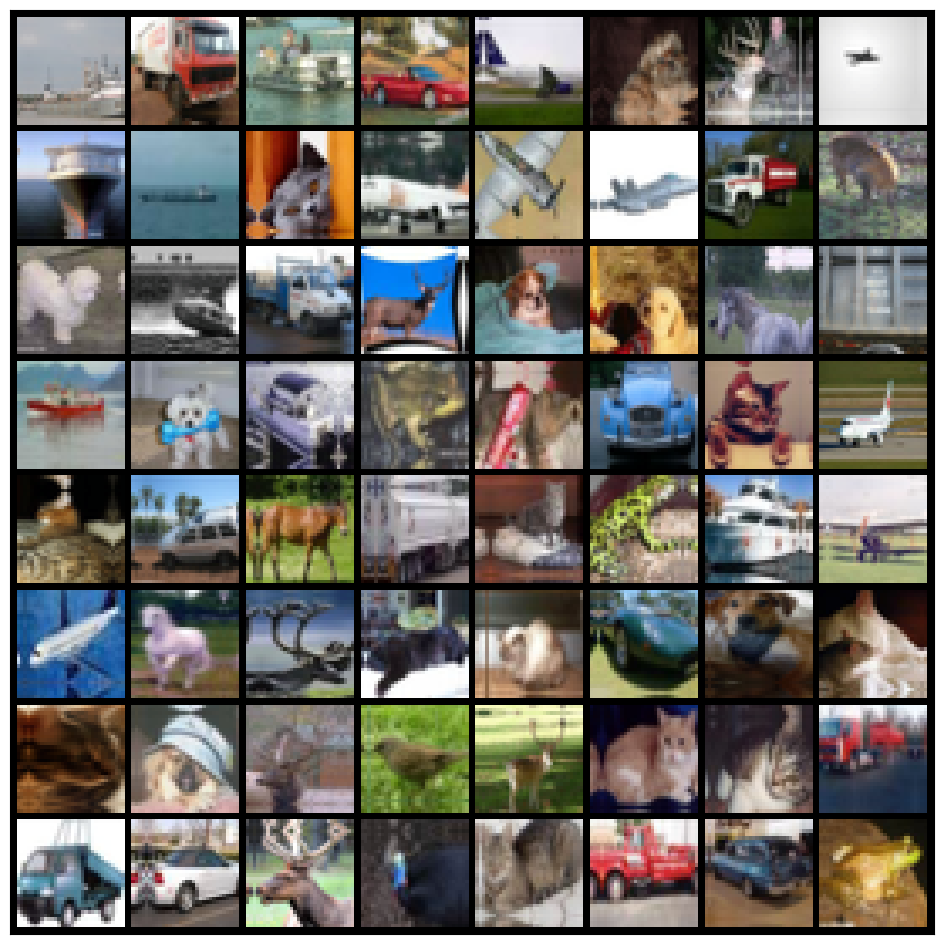

In [12]:
show_batch(train_dl)

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
# device = get_default_device()
# print(device)


device = torch.device("cpu")

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Here is a very simple Residual block:


In [24]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1
        )
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1
        )
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return (
            self.relu2(out) + x
        )  # ReLU can be applied before or after adding the input

In [18]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


This seeming small change produces a drastic improvement in the performance of the model. Also, after each convolutional layer, we'll add a batch normalization layer, which normalizes the outputs of the previous layer.

Go through the following blog posts to learn more:

- Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
- Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd

We will use the ResNet9 architecture, as described in [this blog series](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/) :

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)


In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch,
                result["lrs"][-1],
                result["train_loss"],
                result["val_loss"],
                result["val_acc"],
            )
        )

In [14]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
        )

    def forward(self, xb):
        # print("input", xb.shape)
        out = self.conv1(xb)
        # print("conv1", out.shape)
        out = self.conv2(out)
        # print("conv2", out.shape)
        out = self.res1(out) + out
        # print("res1", out.shape)
        out = self.conv3(out)
        # print("conv3", out.shape)
        out = self.conv4(out)
        # print("conv4", out.shape)
        out = self.res2(out) + out
        # print("res2", out.shape)
        out = self.classifier(out)
        # print("classifier", out.shape)
        return out

In [22]:
for img in train_dl:
    print(img[0].shape)
    break

print(train_dl.__len__())

torch.Size([256, 3, 32, 32])
196


In [15]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def fit_one_cycle(
    epochs,
    max_lr,
    model,
    train_loader,
    val_loader,
    weight_decay=0,
    grad_clip=None,
    opt_func=torch.optim.SGD,
):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)
    )

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
# inital accuracy without training
history = [evaluate(model, valid_dl)]
history

input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([512, 3, 32, 32])
input torch.Size([272, 3, 32, 32])


[{'val_loss': 2.304438352584839, 'val_acc': 0.09785155951976776}]

In [18]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [19]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func,)

input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([256, 3, 32, 32])
input torch.Size([25

KeyboardInterrupt: 

In [42]:
def plot_accuracies(history):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")
    # save the plot
    plt.savefig("accuracy.png")

In [43]:
plot_accuracies(history)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000225A2B114E0>
Traceback (most recent call last):
  File "c:\Users\peter\miniconda3\envs\my_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\peter\miniconda3\envs\my_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\peter\miniconda3\envs\my_env\Lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\peter\miniconda3\envs\my_env\Lib\multiprocessing\popen_spawn_win32.py", line 112, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 


In [ ]:
def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get("lrs", []) for x in history])
    plt.plot(lrs)
    plt.xlabel("Batch no.")
    plt.ylabel("Learning rate")
    plt.title("Learning Rate vs. Batch no.")

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print("Label:", train_ds.classes[label], ", Predicted:", predict_image(img, model))

In [ ]:
%pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(
    arch="resnet9",
    epochs=epochs,
    lr=max_lr,
    scheduler="one-cycle",
    weight_decay=weight_decay,
    grad_clip=grad_clip,
    opt=opt_func.__name__,
)

In [ ]:
train_time = "4:24"

In [ ]:
jovian.log_metrics(
    val_loss=history[-1]["val_loss"],
    val_acc=history[-1]["val_acc"],
    train_loss=history[-1]["train_loss"],
    time=train_time,
)